In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as datasets
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [2]:
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 22.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
features = {}

def hook_fn(name):
    def hook(module, input, output):
        features[name] = output.detach()
    return hook

model.layer1.register_forward_hook(hook_fn("layer1"))
model.layer3.register_forward_hook(hook_fn("layer3"))

In [4]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [6]:
img = Image.open("/content/test_bird.png").convert("RGB")  # upload one image
x_clean = transform(img).unsqueeze(0).to(device)

In [7]:
def gaussian_noise(x, std):
    return x + std * torch.randn_like(x)

def gaussian_blur(img, radius):
    return img.filter(Image.Filter.GaussianBlur(radius))

def occlusion(x, size=50):
    x = x.clone()
    _, _, h, w = x.shape
    x[:, :, h//2-size:h//2+size, w//2-size:w//2+size] = 0
    return x

In [8]:
with torch.no_grad():
    _ = model(x_clean)

clean_feats = {
    k: features[k].flatten(start_dim=1) for k in features
}

In [9]:
noise_levels = np.linspace(0.0, 0.5, 6)

similarities_layer1 = []
similarities_layer3 = []

for std in noise_levels:
    x_noisy = gaussian_noise(x_clean, std)

    with torch.no_grad():
        _ = model(x_noisy)

    noisy_feats = {
        k: features[k].flatten(start_dim=1) for k in features
    }

    sim_l1 = F.cosine_similarity(clean_feats["layer1"], noisy_feats["layer1"]).mean().item()
    sim_l3 = F.cosine_similarity(clean_feats["layer3"], noisy_feats["layer3"]).mean().item()

    similarities_layer1.append(sim_l1)
    similarities_layer3.append(sim_l3)

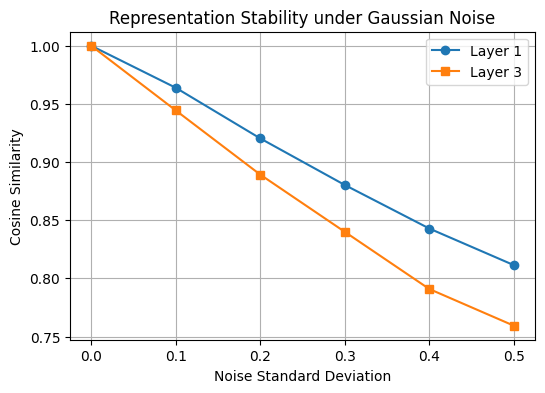

In [10]:
plt.figure(figsize=(6,4))
plt.plot(noise_levels, similarities_layer1, marker="o", label="Layer 1")
plt.plot(noise_levels, similarities_layer3, marker="s", label="Layer 3")

plt.xlabel("Noise Standard Deviation")
plt.ylabel("Cosine Similarity")
plt.title("Representation Stability under Gaussian Noise")
plt.legend()
plt.grid(True)
plt.show()

### Outcome:

### Observations and Interpretation

As Gaussian noise strength increases, cosine similarity between clean and perturbed representations decreases monotonically for both early and deeper layers. This indicates progressive instability of learned representations under input-level perturbations.

Layer 1 representations remain consistently more similar to the clean baseline than Layer 3 across all noise levels. This suggests that early convolutional layers, which primarily encode local and low-level features, degrade more gracefully under random noise. In contrast, deeper representations exhibit a sharper decline in similarity, indicating higher sensitivity to accumulated perturbations.

These results suggest a depth-dependent trade-off: deeper layers provide abstraction and invariance under mild perturbations but may suffer greater representational collapse under severe noise. This highlights that robustness in deep networks is not uniform across depth and depends on both architectural design and perturbation strength.
